# EDA

In [1]:
# pip install pandas

In [2]:
# pip install pyarrow

#### IMPORT DES DONNEES

In [3]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
import pandas as pd
data = pd.read_csv("../SBAnational.csv", low_memory=False)
data = data.drop(['ChgOffDate', 'DisbursementDate', 'DisbursementGross','BalanceGross', 'ChgOffPrinGr'], axis=1)
data.head(1)

,LoanNr_ChkDgt,Name,City,State,Zip,Bank,BankState,NAICS,ApprovalDate,ApprovalFY,...,NewExist,CreateJob,RetainedJob,FranchiseCode,UrbanRural,RevLineCr,LowDoc,MIS_Status,GrAppv,SBA_Appv
0,1000014003,ABC HOBBYCRAFT,EVANSVILLE,IN,47711,FIFTH THIRD BANK,OH,451120,28-Feb-97,1997,...,2.0,0,0,1,0,N,Y,P I F,"$60,000.00","$48,000.00"


In [5]:
data_secteurs = pd.read_csv("../csv_secteursactivite.csv")
data_secteurs = data_secteurs.drop("Default rate (%)", axis=1)

# Modification de certaines valeurs 
mapping = {"31–33": "31", "44–45": "44", "48–49": "48"}
data_secteurs['2 digit code'] = data_secteurs['2 digit code'].replace(mapping)

# Création et Ajout de nouvelles lignes
nouvelles_lignes = [{'2 digit code': 32, 'Description': 'Manufacturing'},
                    {'2 digit code': 33, 'Description': 'Manufacturing'},
                    {'2 digit code': 45, 'Description': 'Retail trade'},
                    {'2 digit code': 49, 'Description': 'Transportation and warehousing'}]

# data_secteurs = data_secteurs.append(nouvelles_lignes, ignore_index=True)

# Concaténation
nouvelles_lignes_df = pd.DataFrame(nouvelles_lignes)
data_secteurs = pd.concat([data_secteurs, nouvelles_lignes_df], ignore_index=True)

# Conversion de la variable en int
data_secteurs["NAICS_id"] = data_secteurs["2 digit code"].astype(int)
data_secteurs = data_secteurs.drop("2 digit code", axis=1)
data_secteurs.head(5)


,Description,NAICS_id
0,"Mining, quarrying, and oil and gas extraction",21
1,"Agriculture, forestry, fishing and hunting",11
2,Management of companies and enterprises,55
3,Health care and social assistance,62
4,Utilities,22


### NETTOYAGE & PREPARATION DES DONNEES

In [6]:
# CONVERSION DES VARIABLES GrAppv ET SBA_Appv EN FORMAT FLOAT
def amount_to_float(s: str) -> float:
    """Converts a 'string' amount in $ to its float value"""
    return float(s[1:].replace(',', ''))

data["GrAppv"] = data["GrAppv"].apply(amount_to_float)
data["SBA_Appv"] = data["SBA_Appv"].apply(amount_to_float)

In [7]:
# CONVERSION DE LA VARIABLE ApprovalFY EN FORMAT INTEGER
def str_to_int(s: str) -> int:
    """Converts a 'string' digit into an integer and deletes string characters if necessary"""
    s = ''.join(char for char in str(s) if char.isdigit())
    return int(s) if s else None

data["ApprovalFY"] = data["ApprovalFY"].apply(str_to_int)

In [8]:
# CONVERSION DE LA VARIABLE ApprovalDate EN FORMAT DATETIME
data['ApprovalDate'] = pd.to_datetime(data['ApprovalDate'], errors='coerce')
data['ApprovalYear'] = data['ApprovalDate'].dt.year
data['ApprovalMonth'] = data['ApprovalDate'].dt.month
data['ApprovalDay'] = data['ApprovalDate'].dt.day
data = data.drop("ApprovalDate", axis=1)
data.head(1)


,LoanNr_ChkDgt,Name,City,State,Zip,Bank,BankState,NAICS,ApprovalFY,Term,...,FranchiseCode,UrbanRural,RevLineCr,LowDoc,MIS_Status,GrAppv,SBA_Appv,ApprovalYear,ApprovalMonth,ApprovalDay
0,1000014003,ABC HOBBYCRAFT,EVANSVILLE,IN,47711,FIFTH THIRD BANK,OH,451120,1997,84,...,1,0,N,Y,P I F,60000.0,48000.0,1997,2,28


In [9]:
from datetime import datetime

# Updated recession periods with the COVID-19 pandemic recession
recession_periods = [
    (1969, 1970),
    (1973, 1975),
    (1980, 1980),
    (1981, 1982),
    (1990, 1991),
    (2001, 2001),
    (2007, 2009),
    (2020, 2020),  # Including the COVID-19 pandemic recession
]

# Function to check if a given year (from dt.year) was in recession
def is_year_in_recession(year):
    # The year parameter is expected to be an integer
    return any(start <= year <= end for start, end in recession_periods)

# Example usage of the function with datetime objects
current_year = datetime.now().year
# print(is_year_in_recession(current_year))  # Example: Check for the current year

data["Recession"] = data["ApprovalYear"].apply(is_year_in_recession)

In [10]:
# CREATION D'UNE AUTRE COLONNE NAICS 
data['NAICS_id'] = data['NAICS'].copy()
data['NAICS_id'] = data['NAICS_id'].astype(str).str[:2]
data['NAICS_id'] = data['NAICS_id'].astype('Int64')

# MERGE AVEC LE DATASET DES SECTEURS D'ACTIVITE
dataset = pd.merge(data, data_secteurs, on='NAICS_id', how='outer')

# SUPPRESSION DE LA COLONNE
# dataset = dataset.drop('NAICS_x', axis=1)
dataset = dataset.rename(columns={"NAICS_y" : "NAICS"})
dataset.head(1)

,LoanNr_ChkDgt,Name,City,State,Zip,Bank,BankState,NAICS,ApprovalFY,Term,...,LowDoc,MIS_Status,GrAppv,SBA_Appv,ApprovalYear,ApprovalMonth,ApprovalDay,Recession,NAICS_id,Description
0,1000014003,ABC HOBBYCRAFT,EVANSVILLE,IN,47711,FIFTH THIRD BANK,OH,451120,1997,84,...,Y,P I F,60000.0,48000.0,1997,2,28,False,45,Retail trade


In [11]:
# CREATION D'UNE COLONNE SameState POUR CAPTURER UNE RELATION ENTRE STATE DU CLIENT ET STATE DE LA BANK
dataset["SameState"] = (dataset['State'] == dataset['BankState']).astype(bool)

In [12]:
dataset = dataset.drop("LoanNr_ChkDgt", axis=1)
dataset.shape

(899164, 27)

In [13]:
# VALEURS NaN SUR TOUT LE DATASET
dataset_nan = dataset[dataset.isna().any(axis=1)]
len(dataset_nan)

209346

In [14]:
# DATASET OU LA TARGET EST REMPLIE DE NaN
MIS_nan = dataset[dataset["MIS_Status"].isna()]
len(MIS_nan)

1997

In [15]:
# CREATION D'UN DATASET SANS LES NaN DANS LA TARGET (il reste des NaN ailleurs qu'il faudra traiter)
dataframe = dataset[dataset["MIS_Status"].isna() == False]
len(dataframe)

897167

In [16]:
# TRANSFORMATION DES VALEURS NaN de NewExist EN 3 (catégorie non renseignée) ET CONVERSION DE LA VARIABLE EN INTEGER
# dataframe["NewExist"] = dataframe["NewExist"].fillna(3, axis=0).astype("Int64")
dataframe.loc[dataframe["NewExist"].isnull(), "NewExist"] = 3
dataframe["NewExist"] = dataframe["NewExist"].astype("Int64")

/tmp/ipykernel_7983/2963248877.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe["NewExist"] = dataframe["NewExist"].astype("Int64")


In [17]:
# import dtale
# dtale.show(data)

In [18]:
dataframe.head(3)

,Name,City,State,Zip,Bank,BankState,NAICS,ApprovalFY,Term,NoEmp,...,MIS_Status,GrAppv,SBA_Appv,ApprovalYear,ApprovalMonth,ApprovalDay,Recession,NAICS_id,Description,SameState
0,ABC HOBBYCRAFT,EVANSVILLE,IN,47711,FIFTH THIRD BANK,OH,451120,1997,84,4,...,P I F,60000.0,48000.0,1997,2,28,False,45,Retail trade,False
1,DEE'S CORNER BAIT & TACKLE,SAINT PETER,MN,56082,WELLS FARGO BANK NATL ASSOC,MN,451110,1997,60,2,...,P I F,39500.0,29625.0,1997,2,28,False,45,Retail trade,True
2,PPP COMMUNICATIONS,WASHINGTON,IA,52353,WASHINGTON STATE BANK,IA,454210,1997,84,2,...,P I F,30000.0,22500.0,1997,2,28,False,45,Retail trade,True


In [19]:
dataframe.NAICS.value_counts()

0         201667
722110     27941
722211     19435
811111     14539
621210     14034
           ...  
111130         1
112420         1
327120         1
111992         1
514190         1
Name: NAICS, Length: 1312, dtype: int64

### SWEETVIZ

In [20]:
# pip install sweetviz

In [21]:
# import sweetviz as sv
# #dataframe = dataframe.dropna()
# dataset['ApprovalFY'] = pd.to_numeric(dataset['ApprovalFY'], errors='coerce').astype('Int64')
# dataset = dataset.dropna()
# my_report = sv.analyze(data)
# my_report.show_html()

### YDATA

In [22]:
# pip install pandas-profiling

In [23]:
# pip install jupyter

In [24]:
# pip install ipywidgets

In [25]:
# from ydata_profiling import ProfileReport
# profile = ProfileReport(data, title="Profiling Report")
# profile

### EDA GRAPHS

#### NAME 

In [26]:
dataset.Name.describe()

count     899150
unique    779583
top       SUBWAY
freq        1269
Name: Name, dtype: object

In [27]:
filtre = dataset.Name.value_counts() == 1
filtre.value_counts()

True     706468
False     73115
Name: Name, dtype: int64

In [28]:
dataset.Name.isnull().sum()
# ON REMPLACE CES VALEURS OU ON LES SUPPR?

14

In [29]:
# CONCLUSION : VARIABLE A SUPPRIMER
# CREER UNE NOUVELLE VARIABLE (UN PRET OU PLUSIEURS PRETS)

#### CITY

In [30]:
dataframe.City.describe()

count          899134
unique          32581
top       LOS ANGELES
freq            11558
Name: City, dtype: object

In [31]:
dataframe.City.isnull().sum()

30

In [32]:
# Suppression ou Remplacement des valeurs manquantes?
# A voir avec ZIP > on va sûrement garder ZIP pour le modèle et suppr cette variable City

In [33]:
# TOP 20 des Villes (Count=Nb de demandes de prêts)
dataframe.groupby("City").count().sort_values(by="Name", ascending=False).head(10)
top10_city = dataframe.groupby("City").count().sort_values(by="Name", ascending=False).reset_index()
top10_city = top10_city[["City", "Name"]]
top10_city = top10_city.rename(columns={"Name" : "Total_Loan_Applications"})
top10_city.head(20)

,City,Total_Loan_Applications
0,LOS ANGELES,11558
1,HOUSTON,10246
2,NEW YORK,7846
3,CHICAGO,6036
4,MIAMI,5594
5,SAN DIEGO,5363
6,DALLAS,5085
7,PHOENIX,4493
8,LAS VEGAS,4390
9,SPRINGFIELD,3738


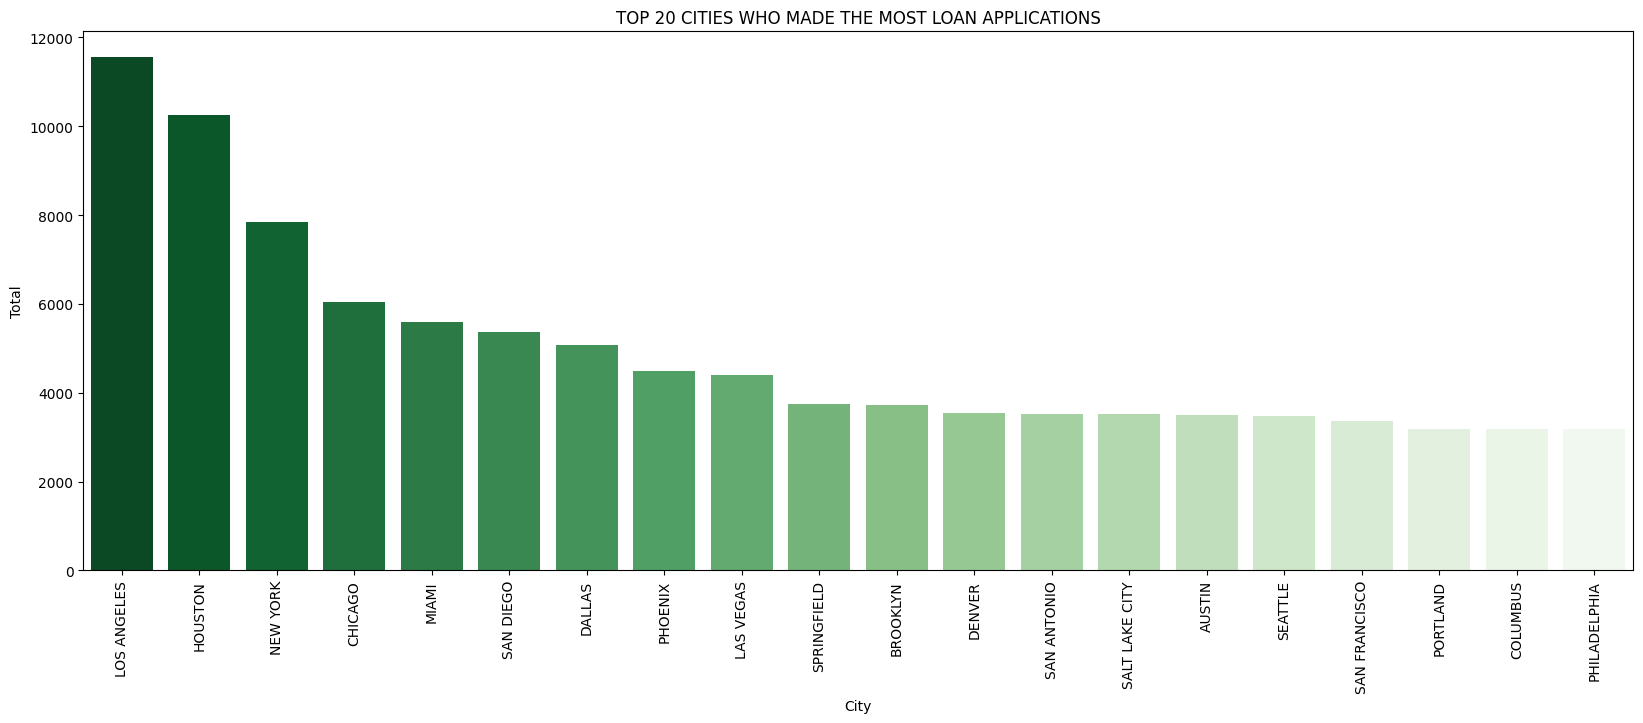

In [34]:
test = dataframe.groupby("City").count().reset_index()
test = test.rename(columns={"Name": "Total"})
test_top = test.sort_values(by="Total", ascending=False).head(20)
test_top = test_top[["City", "Total"]]
plt.figure(figsize=(20,7))
plt.title("TOP 20 CITIES WHO MADE THE MOST LOAN APPLICATIONS")
sns.barplot(test_top, x='City', y="Total", palette="Greens_r")
plt.xticks(rotation='vertical')
plt.show()

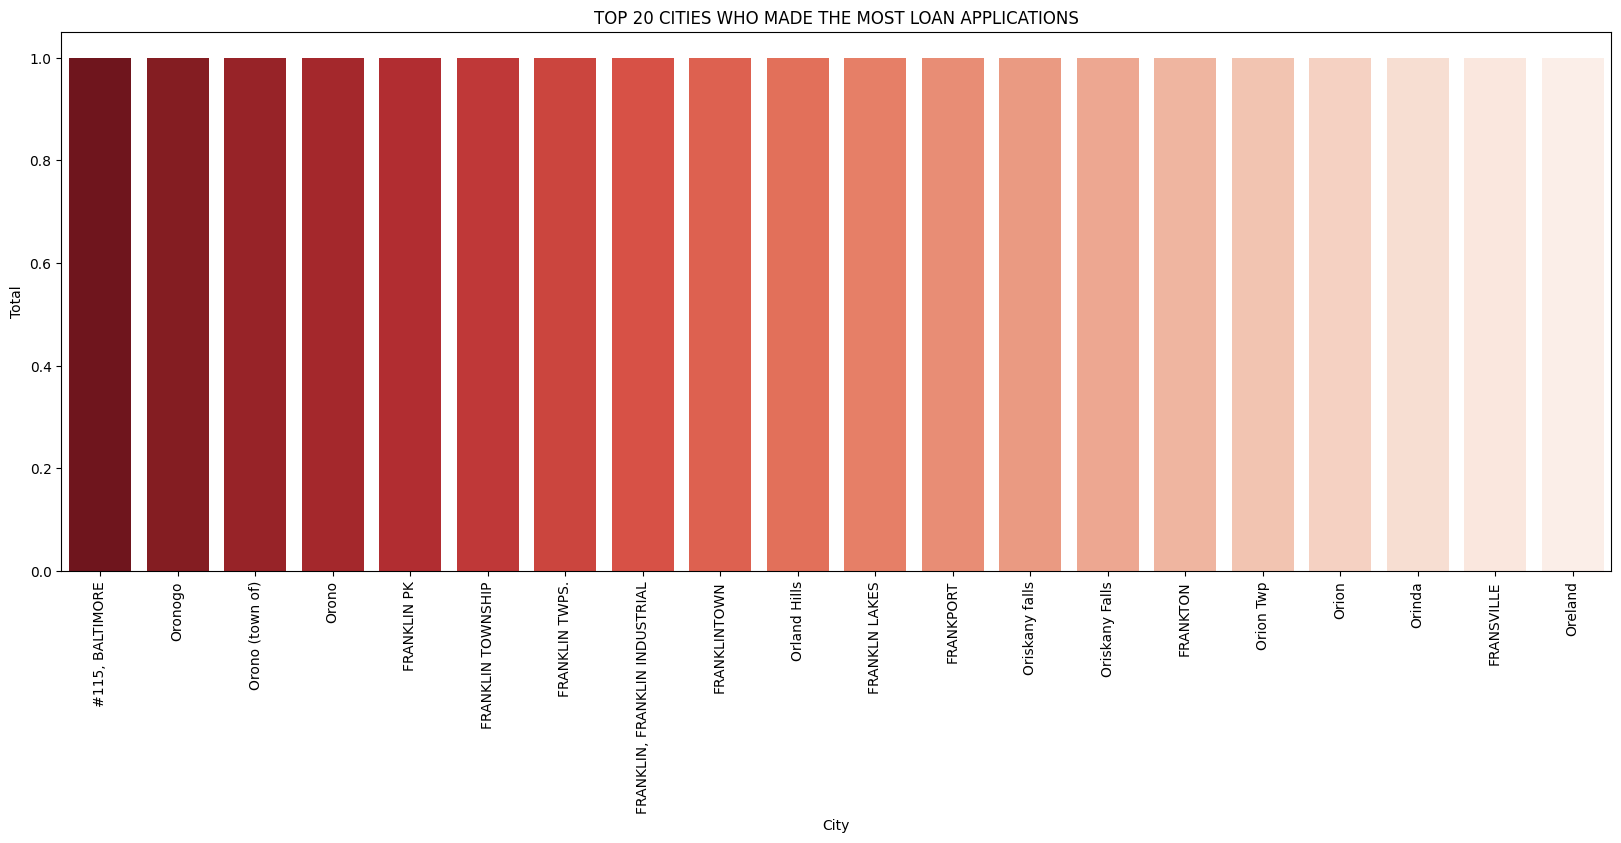

In [35]:
test_flop = test.sort_values(by="Total", ascending=True).head(20)
test_flop = test_flop[["City", "Total"]]
plt.figure(figsize=(20,7))
plt.title("TOP 20 CITIES WHO MADE THE MOST LOAN APPLICATIONS")
sns.barplot(test_flop, x='City', y="Total", palette="Reds_r")
plt.xticks(rotation='vertical')
plt.show()

In [36]:
# ON PEUT REGROUPER PAR ANNEE AUSSI

In [37]:
test2 = dataframe.groupby(["City", "ApprovalYear"]).count().reset_index()
test2 = test2.sort_values(by="Name", ascending=False)
test2.head(20)

,City,ApprovalYear,Name,State,Zip,Bank,BankState,NAICS,ApprovalFY,Term,...,LowDoc,MIS_Status,GrAppv,SBA_Appv,ApprovalMonth,ApprovalDay,Recession,NAICS_id,Description,SameState
85750,LOS ANGELES,2004,1502,1502,1502,1502,1502,1502,1502,1502,...,1502,1501,1502,1502,1502,1502,1502,1502,1502,1502
85753,LOS ANGELES,2007,1312,1312,1312,1312,1312,1312,1312,1312,...,1312,1312,1312,1312,1312,1312,1312,1312,1312,1312
85749,LOS ANGELES,2003,1237,1237,1237,1237,1237,1237,1237,1237,...,1237,1236,1237,1237,1237,1237,1237,1237,1237,1237
85752,LOS ANGELES,2006,1014,1014,1014,1014,1014,1014,1014,1014,...,1014,1014,1014,1014,1014,1014,1014,1014,1014,1014
105388,NEW YORK,2004,1010,1010,1010,1010,1010,1010,1010,1010,...,1010,1007,1010,1010,1010,1010,1010,1010,1010,1010
85751,LOS ANGELES,2005,984,984,984,984,984,984,984,984,...,984,984,984,984,984,984,984,984,984,984
105390,NEW YORK,2006,941,941,941,941,941,941,941,941,...,941,940,941,941,941,941,941,941,941,941
68683,HOUSTON,2006,917,917,917,917,917,917,917,917,...,917,916,917,917,917,917,917,917,917,917
68681,HOUSTON,2004,899,899,899,899,899,899,899,899,...,899,899,899,899,899,899,899,899,899,899
25895,CHICAGO,2006,887,887,887,887,887,887,887,887,...,887,884,887,887,887,887,887,887,887,887


In [38]:
dataframe.ApprovalYear.describe()

count    899164.000000
mean       2000.927535
std           5.963112
min        1974.000000
25%        1996.000000
50%        2002.000000
75%        2006.000000
max        2073.000000
Name: ApprovalYear, dtype: float64

#### STATE

In [39]:
dataframe.State.describe()

count     899150
unique        51
top           CA
freq      130619
Name: State, dtype: object

In [40]:
dataframe.State.isnull().sum()

14

In [42]:
# Valeurs manquantes à REMPLACER
dataframe.query("State.isna()")

,Name,City,State,Zip,Bank,BankState,NAICS,ApprovalFY,Term,NoEmp,...,MIS_Status,GrAppv,SBA_Appv,ApprovalYear,ApprovalMonth,ApprovalDay,Recession,NAICS_id,Description,SameState
17508,"GOLF SHOES UNLIMITED, INC.",PALM BEACH GARDENS,NaN,33410,"BEAL BANK, SSB",TX,451110,1990,84,3,...,P I F,75000.0,67500.0,1989,10,19,False,45,Retail trade,False
171692,SO. JERSEY DANCE/MERRYLEES,PENNSVILLE,NaN,8070,NaN,NaN,0,1981,120,1,...,NaN,15000.0,15000.0,1981,7,28,True,0,NaN,False
173972,TRYON COATS & LEATHER,JOHNSTOWN NY,NaN,0,KEYBANK NATIONAL ASSOCIATION,NY,0,1966,282,0,...,CHGOFF,60000.0,54000.0,2066,5,18,False,0,NaN,False
215643,CENTURY 21 PHILLIPS REALTY,CAMERON PARK,NaN,95682,SBA - EDF ENFORCEMENT ACTION,CO,0,1987,240,19,...,P I F,83000.0,83000.0,1987,2,12,False,0,NaN,False
239091,CASCO SERVICE,CASCO,NaN,54205,UNION STATE BANK,WI,0,1990,204,8,...,P I F,300000.0,252600.0,1989,10,19,False,0,NaN,False
239356,P & P TOOL INC,SOMERSET,NaN,54025,FIRST BANK OF BALDWIN,WI,0,1990,240,7,...,P I F,82000.0,73800.0,1989,10,26,False,0,NaN,False
360560,"VERANDA INTERIORS, INC.",A452638533,NaN,76645,PROSPERITY BANK,TX,0,1997,120,3,...,P I F,100000.0,80000.0,1996,10,24,False,0,NaN,False
433033,KING'S TRUCK WASH,WICHITA,NaN,67219,SOUTH CENT. KANSAS ECONOMIC DE,KS,811192,1988,120,17,...,P I F,119000.0,119000.0,1988,8,5,False,81,Other services (except public administration),False
543561,"OLSON ELECTRIC SERVICE, INC.",A452638533,NaN,75236,PROSPERITY BANK,TX,235310,1996,60,17,...,P I F,40000.0,32000.0,1996,7,9,False,23,Construction,False
543652,METRO SHEETMETAL & ERECTION,A452638533,NaN,76052,PROSPERITY BANK,TX,235610,1996,84,3,...,P I F,80000.0,64000.0,1996,7,23,False,23,Construction,False


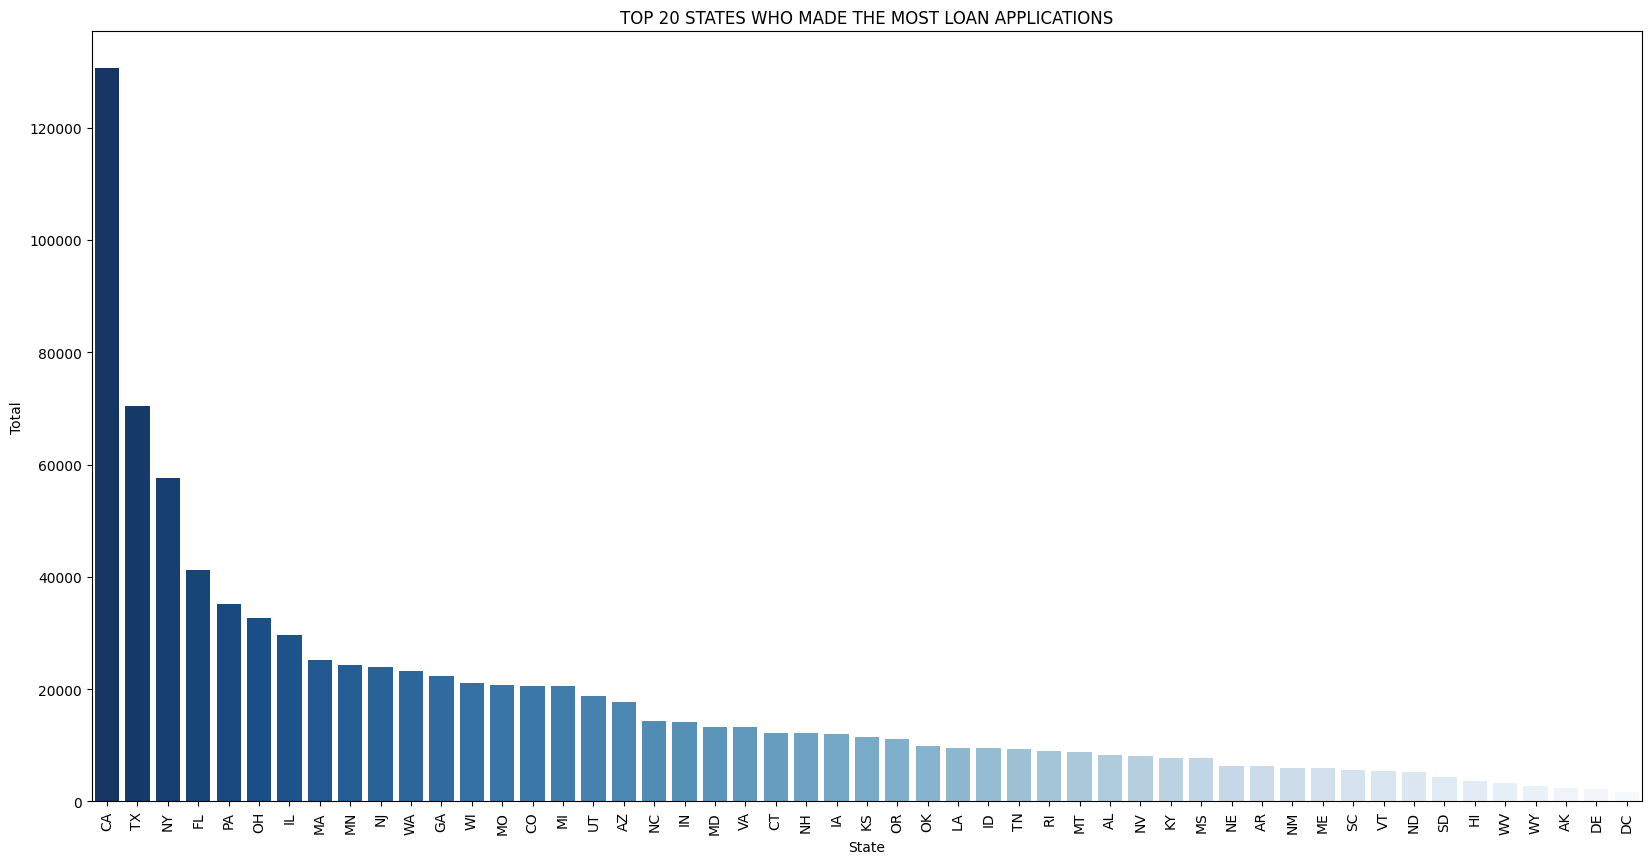

In [51]:
test = dataframe.groupby("State").count().reset_index()
test = test.rename(columns={"Name": "Total"})
test_top = test.sort_values(by="Total", ascending=False)
test_top = test_top[["State", "Total"]]
plt.figure(figsize=(20,10))
plt.title("TOP 20 STATES WHO MADE THE MOST LOAN APPLICATIONS")
sns.barplot(test_top, x='State', y="Total", palette="Blues_r")
plt.xticks(rotation='vertical')
plt.show()

#### ZIP

In [52]:
dataframe.Zip.isnull().sum()

0

In [53]:
dataframe.Zip.describe()

count    899164.000000
mean      53804.391241
std       31184.159152
min           0.000000
25%       27587.000000
50%       55410.000000
75%       83704.000000
max       99999.000000
Name: Zip, dtype: float64

#### BANK

In [55]:
dataframe.Bank.describe()

count                         895661
unique                          5801
top       BANK OF AMERICA NATL ASSOC
freq                           86773
Name: Bank, dtype: object

In [56]:
# QUE FAIRE DES NaN?
dataframe.Bank.isnull().sum()

1506

#### BANKSTATE

In [57]:
dataframe.BankState.describe()

count     895654
unique        56
top           CA
freq      118034
Name: BankState, dtype: object

In [58]:
# QUE FAIRE DES NaN?
dataframe.BankState.isnull().sum()

1513

#### NAICS (aka : Description & NAICS_id)

In [65]:
dataframe.Description.isnull().sum()

201667

In [63]:
dataframe.Description.value_counts()

Retail trade                                                     126975
Other services (except public administration)                     72395
Professional, scientific, and technical services                  67922
Manufacturing                                                     67903
Accommodation and food services                                   67511
Construction                                                      66492
Health care and social assistance                                 55264
Wholesale trade                                                   48673
Administrative/support & waste management/remediation Service     32529
Transportation and warehousing                                    22408
Arts, entertainment, and recreation                               14616
Real estate and rental and leasing                                13588
Information                                                       11362
Finance and insurance                                           

In [70]:
dataframe.Description = dataframe.Description.fillna("Unknown")

/tmp/ipykernel_7983/1117963697.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe.Description = dataframe.Description.fillna("Unknown")


In [72]:
#dataframe.query("Description.isna()")
dataframe.Description.value_counts()

Unknown                                                          201667
Retail trade                                                     126975
Other services (except public administration)                     72395
Professional, scientific, and technical services                  67922
Manufacturing                                                     67903
Accommodation and food services                                   67511
Construction                                                      66492
Health care and social assistance                                 55264
Wholesale trade                                                   48673
Administrative/support & waste management/remediation Service     32529
Transportation and warehousing                                    22408
Arts, entertainment, and recreation                               14616
Real estate and rental and leasing                                13588
Information                                                     

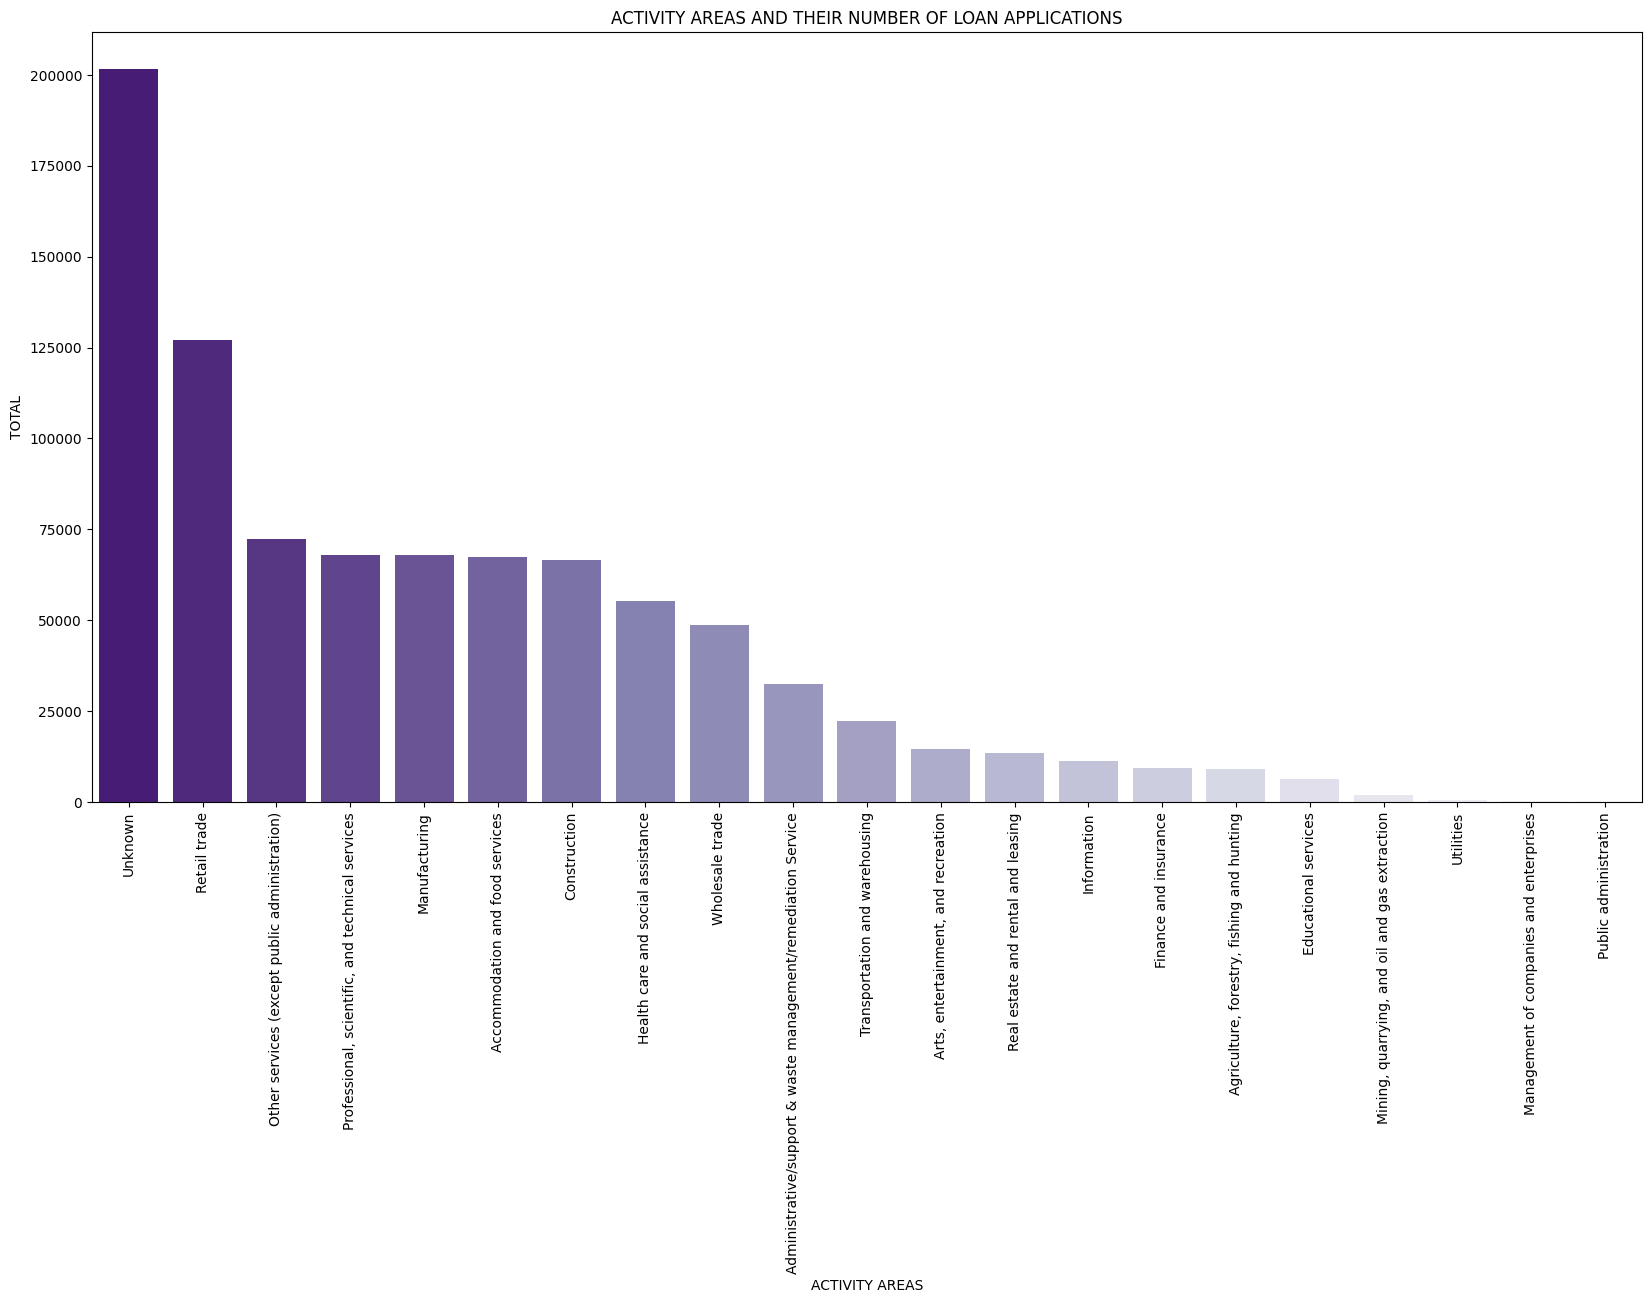

In [78]:
test = dataframe.groupby("Description").count().reset_index()
test = test.rename(columns={"Name": "Total"})
test_top = test.sort_values(by="Total", ascending=False)
test_top = test_top[["Description", "Total"]]
plt.figure(figsize=(20,10))
plt.title("ACTIVITY AREAS AND THEIR NUMBER OF LOAN APPLICATIONS")
sns.barplot(test_top, x='Description', y="Total", palette="Purples_r")
plt.xticks(rotation='vertical')
plt.xlabel("ACTIVITY AREAS")
plt.ylabel("TOTAL")
plt.show()

In [73]:
dataframe.NAICS_id.isnull().sum()

0

# MACHINE LEARNING

### PYCARET

In [ ]:
#pip install pycaret

In [ ]:
from pycaret.classification import *
df_test = data.copy()
df_test = df_test.dropna()
session = setup(data=dataframe, target='MIS_Status', normalize=True, train_size=0.8, fold=3, data_split_stratify=True, session_id=0)

,Description,Value
0,Session id,0
1,Target,MIS_Status
2,Target type,Binary
3,Target mapping,"CHGOFF: 0, P I F: 1"
4,Original data shape,"(897167, 27)"
5,Transformed data shape,"(897167, 67)"
6,Transformed train set shape,"(717733, 67)"
7,Transformed test set shape,"(179434, 67)"
8,Numeric features,16
9,Categorical features,8


In [ ]:
algo = models()
print(algo)

                                     Name  \
ID                                          
lr                    Logistic Regression   
knn                K Neighbors Classifier   
nb                            Naive Bayes   
dt               Decision Tree Classifier   
svm                   SVM - Linear Kernel   
rbfsvm                SVM - Radial Kernel   
gpc           Gaussian Process Classifier   
mlp                        MLP Classifier   
ridge                    Ridge Classifier   
rf               Random Forest Classifier   
qda       Quadratic Discriminant Analysis   
ada                  Ada Boost Classifier   
gbc          Gradient Boosting Classifier   
lda          Linear Discriminant Analysis   
et                 Extra Trees Classifier   
xgboost         Extreme Gradient Boosting   
lightgbm  Light Gradient Boosting Machine   
catboost              CatBoost Classifier   
dummy                    Dummy Classifier   

                                                  Refe

In [ ]:
# from pycaret.classification import compare_models
# top_models = compare_models(sort="Recall")
# print(top_models)